In [59]:
# Ensure we are in the correct directory #
#----------------------------------------#

%cd ~/Documents/contabo/equity2/dashboard/playground/buy_the_dip
%pwd

/Users/ludwigjonsson/Documents/contabo/equity2/dashboard/playground/buy_the_dip


/Users/ludwigjonsson/Documents/contabo/equity2/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/Users/ludwigjonsson/Documents/contabo/equity2/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/Users/ludwigjonsson/Documents/contabo/equity2/dashboard/playground/buy_the_dip'

In [2]:
# Set up current notebook #
#-------------------------#

try: IS_MASTER
except: IS_MASTER = False

if not IS_MASTER:
    DATA_DIR = './data'
    RAW_FILE = f'{DATA_DIR}/ftse.csv' # f'{DATA_DIR}/nasdaq.csv'
    PROCESSED_FILE = f'{DATA_DIR}/processed.pkl'

    '''
    ^FTSE
    ISF.L  # 1x FTSE
    LUK2.L # 2x FTSE
    3UKL.L # 3x FTSE
    '''

    OTHER_PREPROCESS_PARAM = {
        'INDEX': '^FTSE',
        'ETF': 'LUK2.L', # '3UKL.L'
        'PRICE_COLS': ['Close', 'High', 'Low', 'Open'],
        'METRIC_COL': 'Close',
        'VOL_COL': 'Volume',
        'DIV_COL': 'Dividends',
        'USE_LOG_METRIC': False
    }


In [3]:
# Import Dependencies #
#---------------------#

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
# Open the CSV file #
#-------------------#

df = pd.read_csv(RAW_FILE)
df.Date = pd.to_datetime(df.Date)

/var/folders/z_/25lkvwgj7gx6vfptzrpwwwrw0000gn/T/ipykernel_12443/2178278754.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  dfPlotRet = dfPlot.pct_change(1)


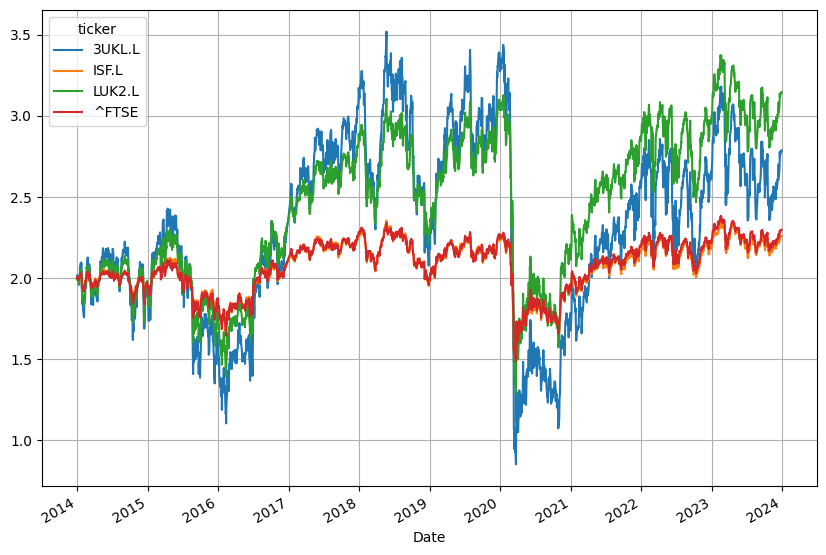

In [5]:
# Pivot and look at columns #
#---------------------------#

df.loc[df.ticker == 'ISF.L'].pivot(columns='metric').describe()

print()

if not IS_MASTER:
    fig, ax = plt.subplots(figsize=(10,7))

    dfPlot = df.loc[df.metric == 'Close'].pivot(index='Date', columns='ticker', values='value')

    dfPlotRet = dfPlot.pct_change(1)
    dfPlotRet = dfPlotRet.fillna(1) + 1

    dfPlotCumRet = dfPlotRet.cumprod()
    dfPlotCumRet.plot(ax=ax)

    ax.grid()

In [6]:
# Drop the empty columns #
#------------------------#

COLUMNS_DROP = ['Capital Gains', 'Stock Splits']

df = df.loc[~df.metric.isin(COLUMNS_DROP)]
df

,Date,metric,ticker,value
5054,2013-12-30,Close,3UKL.L,15409.0
5055,2013-12-31,Close,3UKL.L,15540.0
5056,2014-01-02,Close,3UKL.L,15400.0
5057,2014-01-03,Close,3UKL.L,15311.0
5058,2014-01-06,Close,3UKL.L,15396.0
...,...,...,...,...
75805,2023-12-21,Volume,^FTSE,603350200.0
75806,2023-12-22,Volume,^FTSE,329604400.0
75807,2023-12-27,Volume,^FTSE,432594200.0
75808,2023-12-28,Volume,^FTSE,327536200.0


In [7]:
# Get The ETFs In Question #
#--------------------------#

ETF = OTHER_PREPROCESS_PARAM['ETF']
PRICE_COLS = OTHER_PREPROCESS_PARAM['PRICE_COLS']
METRIC_COL = OTHER_PREPROCESS_PARAM['METRIC_COL']
DIV_COL = OTHER_PREPROCESS_PARAM['DIV_COL']
VOL_COL = OTHER_PREPROCESS_PARAM['VOL_COL']

dfETF = df.loc[df.ticker == ETF].pivot(columns='metric', index='Date', values='value')
dfETF = dfETF.astype('float64')

dfETF

metric,Close,Dividends,High,Low,Open,Volume
Date,,,,,,
2013-12-30,22457.5,0.0,22608.449219,22292.000000,22470.0,5998.0
2013-12-31,22485.5,0.0,22550.000000,22430.150391,22489.0,6716.0
2014-01-02,22301.0,0.0,22562.949219,22148.400391,22440.0,8006.0
2014-01-03,22323.0,0.0,22459.000000,22195.150391,22312.0,2567.0
2014-01-06,22352.0,0.0,22481.000000,22274.949219,22365.0,7466.0
...,...,...,...,...,...,...
2023-12-21,35017.5,0.0,35135.000000,34800.000000,35010.0,4658.0
2023-12-22,35107.5,0.0,35115.000000,34916.250000,35115.0,1005.0
2023-12-27,35302.5,0.0,35470.000000,35170.000000,35265.0,3979.0


In [8]:
# Compute The Spreads In Price #
#------------------------------#

HIGH_LOW = 'HighLow_Spread'
OPEN_CLOSE = 'OpenClose_Spread'

# Close - Open

dfETF[OPEN_CLOSE] = dfETF['Close'] - dfETF['Open']

# High - Low

dfETF[HIGH_LOW] = dfETF['High'] - dfETF['Low']

dfETF

metric,Close,Dividends,High,Low,Open,Volume,OpenClose_Spread,HighLow_Spread
Date,,,,,,,,
2013-12-30,22457.5,0.0,22608.449219,22292.000000,22470.0,5998.0,-12.5,316.449219
2013-12-31,22485.5,0.0,22550.000000,22430.150391,22489.0,6716.0,-3.5,119.849609
2014-01-02,22301.0,0.0,22562.949219,22148.400391,22440.0,8006.0,-139.0,414.548828
2014-01-03,22323.0,0.0,22459.000000,22195.150391,22312.0,2567.0,11.0,263.849609
2014-01-06,22352.0,0.0,22481.000000,22274.949219,22365.0,7466.0,-13.0,206.050781
...,...,...,...,...,...,...,...,...
2023-12-21,35017.5,0.0,35135.000000,34800.000000,35010.0,4658.0,7.5,335.000000
2023-12-22,35107.5,0.0,35115.000000,34916.250000,35115.0,1005.0,-7.5,198.750000
2023-12-27,35302.5,0.0,35470.000000,35170.000000,35265.0,3979.0,37.5,300.000000


In [9]:
# Compute The Dividend Adj Price #
#--------------------------------#

METRIC_ADJ_COL = f'{METRIC_COL}Adj'

dfETFMetric = dfETF[[METRIC_COL, VOL_COL, DIV_COL, HIGH_LOW, OPEN_CLOSE]]

if OTHER_PREPROCESS_PARAM['USE_LOG_METRIC']:
    dfETFMetric[METRIC_COL] = np.log(dfETFMetric[METRIC_COL])

dfETFMetric[METRIC_ADJ_COL] = dfETFMetric[METRIC_COL] + dfETFMetric[DIV_COL]

dfETFMetric

/var/folders/z_/25lkvwgj7gx6vfptzrpwwwrw0000gn/T/ipykernel_12443/1146473025.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfETFMetric[METRIC_ADJ_COL] = dfETFMetric[METRIC_COL] + dfETFMetric[DIV_COL]


metric,Close,Volume,Dividends,HighLow_Spread,OpenClose_Spread,CloseAdj
Date,,,,,,
2013-12-30,22457.5,5998.0,0.0,316.449219,-12.5,22457.5
2013-12-31,22485.5,6716.0,0.0,119.849609,-3.5,22485.5
2014-01-02,22301.0,8006.0,0.0,414.548828,-139.0,22301.0
2014-01-03,22323.0,2567.0,0.0,263.849609,11.0,22323.0
2014-01-06,22352.0,7466.0,0.0,206.050781,-13.0,22352.0
...,...,...,...,...,...,...
2023-12-21,35017.5,4658.0,0.0,335.000000,7.5,35017.5
2023-12-22,35107.5,1005.0,0.0,198.750000,-7.5,35107.5
2023-12-27,35302.5,3979.0,0.0,300.000000,37.5,35302.5


In [10]:
# Compute The Volatility #
#------------------------#

VOLATIL_WINDOW = 14

STD_COL = f'{METRIC_ADJ_COL}_STD{VOLATIL_WINDOW}'
VOLATIL_COL = f'{METRIC_ADJ_COL}_VOLATIL{VOLATIL_WINDOW}'

dfETFMetric[STD_COL] = dfETFMetric[METRIC_ADJ_COL].rolling(VOLATIL_WINDOW).std()
dfETFMetric[VOLATIL_COL] = (np.sqrt(252) * dfETFMetric[STD_COL]) / dfETFMetric[METRIC_ADJ_COL]

dfETFMetric

/var/folders/z_/25lkvwgj7gx6vfptzrpwwwrw0000gn/T/ipykernel_12443/4176444113.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfETFMetric[STD_COL] = dfETFMetric[METRIC_ADJ_COL].rolling(VOLATIL_WINDOW).std()


metric,Close,Volume,Dividends,HighLow_Spread,OpenClose_Spread,CloseAdj,CloseAdj_STD14,CloseAdj_VOLATIL14
Date,,,,,,,,
2013-12-30,22457.5,5998.0,0.0,316.449219,-12.5,22457.5,NaN,NaN
2013-12-31,22485.5,6716.0,0.0,119.849609,-3.5,22485.5,NaN,NaN
2014-01-02,22301.0,8006.0,0.0,414.548828,-139.0,22301.0,NaN,NaN
2014-01-03,22323.0,2567.0,0.0,263.849609,11.0,22323.0,NaN,NaN
2014-01-06,22352.0,7466.0,0.0,206.050781,-13.0,22352.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-21,35017.5,4658.0,0.0,335.000000,7.5,35017.5,614.628925,0.278630
2023-12-22,35107.5,1005.0,0.0,198.750000,-7.5,35107.5,648.009844,0.293010
2023-12-27,35302.5,3979.0,0.0,300.000000,37.5,35302.5,658.526624,0.296120


In [11]:
# Compute The VWAP of Adjusted Prices #
#-------------------------------------#

VWAP_WINDOW = 14
VWAP_COLS = []

def vwap(series, priceCol, volCol):
    index = series.index
    df = dfETFMetric.loc[index]

    volSum = df[volCol].sum()
    volWeighted = df[priceCol] * df[volCol]
    volWeightedPrice = volWeighted / volSum
    vwaPrice = volWeightedPrice.sum()

    return vwaPrice

METRIC_VWAP_COL = f'{METRIC_ADJ_COL}_VWAP{VWAP_WINDOW}'

dfETFMetric[METRIC_VWAP_COL] = dfETFMetric[VOL_COL].rolling(VWAP_WINDOW).apply(vwap, args=(METRIC_ADJ_COL, VOL_COL))

METRIC_VWAP_SPREAD_COL = f'{METRIC_VWAP_COL}_Spread'

dfETFMetric[METRIC_VWAP_SPREAD_COL] = dfETFMetric[METRIC_ADJ_COL] - dfETFMetric[METRIC_VWAP_COL]

dfETFMetric

metric,Close,Volume,Dividends,HighLow_Spread,OpenClose_Spread,CloseAdj,CloseAdj_STD14,CloseAdj_VOLATIL14,CloseAdj_VWAP14,CloseAdj_VWAP14_Spread
Date,,,,,,,,,,
2013-12-30,22457.5,5998.0,0.0,316.449219,-12.5,22457.5,NaN,NaN,NaN,NaN
2013-12-31,22485.5,6716.0,0.0,119.849609,-3.5,22485.5,NaN,NaN,NaN,NaN
2014-01-02,22301.0,8006.0,0.0,414.548828,-139.0,22301.0,NaN,NaN,NaN,NaN
2014-01-03,22323.0,2567.0,0.0,263.849609,11.0,22323.0,NaN,NaN,NaN,NaN
2014-01-06,22352.0,7466.0,0.0,206.050781,-13.0,22352.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-21,35017.5,4658.0,0.0,335.000000,7.5,35017.5,614.628925,0.278630,34343.980716,673.519284
2023-12-22,35107.5,1005.0,0.0,198.750000,-7.5,35107.5,648.009844,0.293010,34375.543747,731.956253
2023-12-27,35302.5,3979.0,0.0,300.000000,37.5,35302.5,658.526624,0.296120,34435.035648,867.464352


In [12]:
# Compute The Z-Score of Relevant Metrics #
#-----------------------------------------#

ZSCORE_WINDOW = 22

ZSCORE_METRIC_COLS = [METRIC_ADJ_COL, VOL_COL, HIGH_LOW, OPEN_CLOSE, METRIC_VWAP_COL, METRIC_VWAP_SPREAD_COL]

ZSCORE_COLS = [f'{col}_ZSCORE{ZSCORE_WINDOW}' for col in ZSCORE_METRIC_COLS]

def zscore(series):
    std = np.std(series)
    mean = np.mean(series)
    seriesZScore = (series - mean)/std

    return seriesZScore.iloc[-1]

for zscoreCol, metricCol in zip(ZSCORE_COLS, ZSCORE_METRIC_COLS):
    dfETFMetric[zscoreCol] = dfETFMetric[metricCol].rolling(ZSCORE_WINDOW).apply(zscore)

dfETFMetric

metric,Close,Volume,Dividends,HighLow_Spread,OpenClose_Spread,CloseAdj,CloseAdj_STD14,CloseAdj_VOLATIL14,CloseAdj_VWAP14,CloseAdj_VWAP14_Spread,CloseAdj_ZSCORE22,Volume_ZSCORE22,HighLow_Spread_ZSCORE22,OpenClose_Spread_ZSCORE22,CloseAdj_VWAP14_ZSCORE22,CloseAdj_VWAP14_Spread_ZSCORE22
Date,,,,,,,,,,,,,,,,
2013-12-30,22457.5,5998.0,0.0,316.449219,-12.5,22457.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,22485.5,6716.0,0.0,119.849609,-3.5,22485.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,22301.0,8006.0,0.0,414.548828,-139.0,22301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,22323.0,2567.0,0.0,263.849609,11.0,22323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,22352.0,7466.0,0.0,206.050781,-13.0,22352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,35017.5,4658.0,0.0,335.000000,7.5,35017.5,614.628925,0.278630,34343.980716,673.519284,1.970649,0.150778,-0.532357,-0.315160,2.235540,1.209777
2023-12-22,35107.5,1005.0,0.0,198.750000,-7.5,35107.5,648.009844,0.293010,34375.543747,731.956253,1.842168,-0.900803,-1.090716,-0.392904,2.014170,1.277705
2023-12-27,35302.5,3979.0,0.0,300.000000,37.5,35302.5,658.526624,0.296120,34435.035648,867.464352,1.840610,-0.051519,-0.621955,-0.153020,1.886143,1.553307


In [13]:
# Compute the Next N bdays Average Price and shift ( N bdays + 22 bdays) #
#------------------------------------------------------------------------#

AVG_WINDOW = 5

METRIC_WEEKLY_AVG_COL = f'{METRIC_ADJ_COL}_AVG{AVG_WINDOW}'
METRIC_WEEKLY_AVG_SHIFT_COL = f'{METRIC_ADJ_COL}_AVG{AVG_WINDOW}_LS{AVG_WINDOW+22}'

dfETFMetric[METRIC_WEEKLY_AVG_COL] = dfETFMetric[METRIC_ADJ_COL].rolling(AVG_WINDOW).mean()

dfETFMetric[METRIC_WEEKLY_AVG_SHIFT_COL] = dfETFMetric[METRIC_WEEKLY_AVG_COL].shift(-(AVG_WINDOW+22))

dfETFMetric

metric,Close,Volume,Dividends,HighLow_Spread,OpenClose_Spread,CloseAdj,CloseAdj_STD14,CloseAdj_VOLATIL14,CloseAdj_VWAP14,CloseAdj_VWAP14_Spread,CloseAdj_ZSCORE22,Volume_ZSCORE22,HighLow_Spread_ZSCORE22,OpenClose_Spread_ZSCORE22,CloseAdj_VWAP14_ZSCORE22,CloseAdj_VWAP14_Spread_ZSCORE22,CloseAdj_AVG5,CloseAdj_AVG5_LS27
Date,,,,,,,,,,,,,,,,,,
2013-12-30,22457.5,5998.0,0.0,316.449219,-12.5,22457.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20760.1
2013-12-31,22485.5,6716.0,0.0,119.849609,-3.5,22485.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20833.2
2014-01-02,22301.0,8006.0,0.0,414.548828,-139.0,22301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20987.4
2014-01-03,22323.0,2567.0,0.0,263.849609,11.0,22323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21268.8
2014-01-06,22352.0,7466.0,0.0,206.050781,-13.0,22352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22383.8,21549.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,35017.5,4658.0,0.0,335.000000,7.5,35017.5,614.628925,0.278630,34343.980716,673.519284,1.970649,0.150778,-0.532357,-0.315160,2.235540,1.209777,34607.0,NaN
2023-12-22,35107.5,1005.0,0.0,198.750000,-7.5,35107.5,648.009844,0.293010,34375.543747,731.956253,1.842168,-0.900803,-1.090716,-0.392904,2.014170,1.277705,34837.0,NaN
2023-12-27,35302.5,3979.0,0.0,300.000000,37.5,35302.5,658.526624,0.296120,34435.035648,867.464352,1.840610,-0.051519,-0.621955,-0.153020,1.886143,1.553307,35036.5,NaN


In [14]:
# Check if it is worthwhile to Invest  #
# +1 if future avg price >=X% return   #
#  0 if future avg price > -X% & < X%  #
# -1 if future avg price <= -X%        #
#--------------------------------------#

SHOULD_INVEST_RET_THRESH = 0.05

METRIC_ADJ_LESS_AVG = f'{METRIC_WEEKLY_AVG_SHIFT_COL}_Spread'
METRIC_ADJ_LESS_AVG_RET = f'{METRIC_WEEKLY_AVG_SHIFT_COL}_Ret'

DIRECTION_COL = 'TradeDirection'

dfETFMetric[METRIC_ADJ_LESS_AVG] = dfETFMetric[METRIC_WEEKLY_AVG_SHIFT_COL] - dfETFMetric[METRIC_ADJ_COL]

dfETFMetric[METRIC_ADJ_LESS_AVG_RET] = dfETFMetric[METRIC_ADJ_LESS_AVG] / dfETFMetric[METRIC_ADJ_COL]

dfETFMetric[DIRECTION_COL] = 0
dfETFMetric.loc[dfETFMetric[METRIC_ADJ_LESS_AVG_RET] < -SHOULD_INVEST_RET_THRESH, DIRECTION_COL] = 0
dfETFMetric.loc[dfETFMetric[METRIC_ADJ_LESS_AVG_RET] > SHOULD_INVEST_RET_THRESH, DIRECTION_COL] = 1

dfETFMetric

metric,Close,Volume,Dividends,HighLow_Spread,OpenClose_Spread,CloseAdj,CloseAdj_STD14,CloseAdj_VOLATIL14,CloseAdj_VWAP14,CloseAdj_VWAP14_Spread,...,Volume_ZSCORE22,HighLow_Spread_ZSCORE22,OpenClose_Spread_ZSCORE22,CloseAdj_VWAP14_ZSCORE22,CloseAdj_VWAP14_Spread_ZSCORE22,CloseAdj_AVG5,CloseAdj_AVG5_LS27,CloseAdj_AVG5_LS27_Spread,CloseAdj_AVG5_LS27_Ret,TradeDirection
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-30,22457.5,5998.0,0.0,316.449219,-12.5,22457.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20760.1,-1697.4,-0.075583,0
2013-12-31,22485.5,6716.0,0.0,119.849609,-3.5,22485.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20833.2,-1652.3,-0.073483,0
2014-01-02,22301.0,8006.0,0.0,414.548828,-139.0,22301.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20987.4,-1313.6,-0.058903,0
2014-01-03,22323.0,2567.0,0.0,263.849609,11.0,22323.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21268.8,-1054.2,-0.047225,0
2014-01-06,22352.0,7466.0,0.0,206.050781,-13.0,22352.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22383.8,21549.3,-802.7,-0.035912,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,35017.5,4658.0,0.0,335.000000,7.5,35017.5,614.628925,0.278630,34343.980716,673.519284,...,0.150778,-0.532357,-0.315160,2.235540,1.209777,34607.0,NaN,NaN,NaN,0
2023-12-22,35107.5,1005.0,0.0,198.750000,-7.5,35107.5,648.009844,0.293010,34375.543747,731.956253,...,-0.900803,-1.090716,-0.392904,2.014170,1.277705,34837.0,NaN,NaN,NaN,0
2023-12-27,35302.5,3979.0,0.0,300.000000,37.5,35302.5,658.526624,0.296120,34435.035648,867.464352,...,-0.051519,-0.621955,-0.153020,1.886143,1.553307,35036.5,NaN,NaN,NaN,0


In [15]:
# Drop the NaN Rows and Extract Relevant Columns #
#------------------------------------------------#

COLUMNS = [METRIC_ADJ_COL, VOL_COL, VOLATIL_COL, HIGH_LOW, OPEN_CLOSE, METRIC_VWAP_COL, METRIC_VWAP_SPREAD_COL, *ZSCORE_COLS, DIRECTION_COL]

dfETFMetricDropped = dfETFMetric.dropna()

dfProcessed = dfETFMetricDropped[COLUMNS]

In [16]:
# Save into Pickle File #
#-----------------------#

dfProcessed.to_pickle(PROCESSED_FILE)